In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as tkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [43]:
df = pd.read_csv("gold_price_data.csv", infer_datetime_format = True, parse_dates = ["Date"])

In [44]:
df.head(10)

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4
5,1971-04-01,38.9
6,1971-07-01,40.1
7,1971-10-01,42.0
8,1972-01-03,43.5
9,1972-04-03,48.3


In [19]:
df.shape

(10787, 2)

In [20]:
df.describe()

,Value
count,10787.000000
mean,653.596634
std,434.030848
min,35.100000
25%,349.200000
50%,409.350000
75%,1061.625000
max,1895.000000


In [21]:
df.isnull().sum()

Date     0
Value    0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10787 non-null  datetime64[ns]
 1   Value   10787 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.7 KB


In [6]:
# Data Visualization..
import seaborn as sns

<AxesSubplot:xlabel='Date', ylabel='Value'>

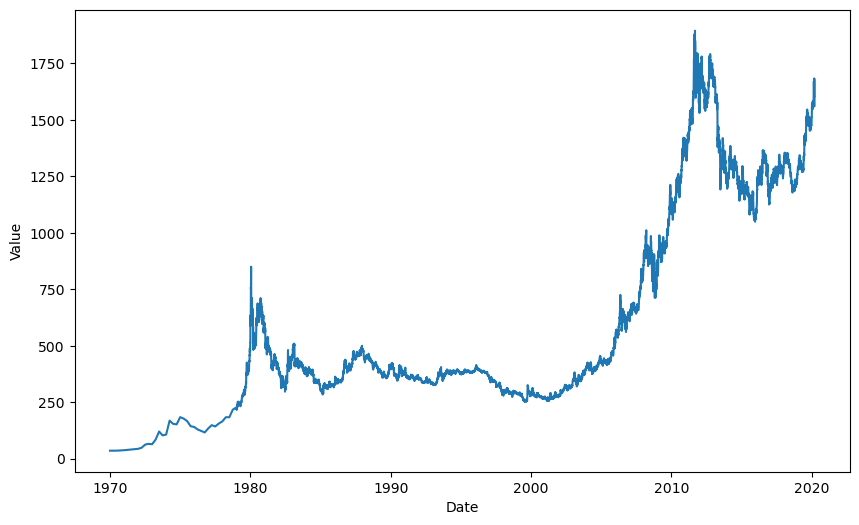

In [23]:
plt.figure(figsize = (10,6))
sns.lineplot(y="Value", x= "Date", data=df)

In [ ]:
# We split first!!!
# And then scale to avoid data leakage..
# and then preprocessing
# Model

In [45]:
X_train = df[:8090]
X_test = df[8090:]

print(X_train.shape)
print(X_test.shape)

(8090, 2)
(2697, 2)


In [46]:
X_train.set_index("Date", inplace=True)
X_test.set_index("Date", inplace=True)

In [18]:
# should be done using moving avg.
Xtrain_mean = X_train.mean()
Xtrain_std = X_train.std()
Xtest_mean = X_test.mean()
Xtest_std = X_test.std()

X_train = (X_train - Xtrain_mean) / Xtrain_std
X_test = (X_test - Xtest_mean) / Xtest_std

In [56]:
X_train.head()

,Value
Date,
1970-01-01,35.2
1970-04-01,35.1
1970-07-01,35.4
1970-10-01,36.2
1971-01-01,37.4


In [9]:
X_test.head()

,Value
Date,
2009-11-12,1114.75
2009-11-13,1104.00
2009-11-16,1130.00
2009-11-17,1134.75
2009-11-18,1149.00


In [47]:
WINDOW_SIZE = 10

In [17]:
#this one's not up to date
#generator_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_train, X_train, length=window_size, batch_size =32)
#generator_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(X_test, X_test, length = window_size, batch_size = 32)

In [23]:
#this one's up to date but didn't work
#input_data = X_train.Value[:-10]
#targets = X_train.Value[10:]
#dataset = tf.keras.utils.timeseries_dataset_from_array(
    #input_data, targets, sequence_length=10)
#for batch in dataset:
  #inputs, targets = batch
  #assert np.array_equal(inputs[0], X_train.Value[:10])  # First sequence: steps [0-9]
  #assert np.array_equal(targets[0], X_train.Value[10])  # Corresponding target: step 10
  #break

In [57]:
df.set_index("Date", inplace=True)

In [62]:
df_v = df["Value"]

<AxesSubplot:xlabel='Date'>

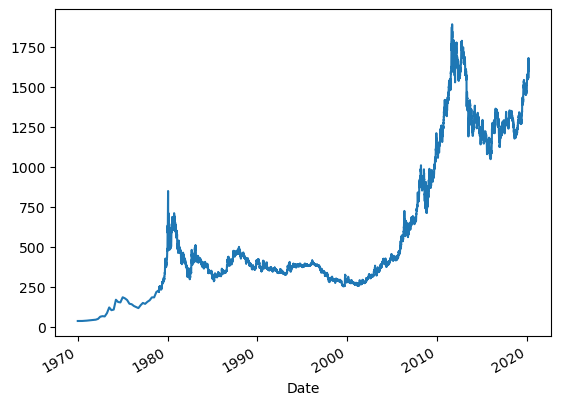

In [65]:
df_v.plot()

In [70]:
#Writing myself instead(turning into a supervised learning problem)
def from_df_to_Xy(window_size, data):
    data_np = df_v.to_numpy()
    X = []
    y = []
    for i in range(len(data_np) - window_size):
        seq = [[a] for a in data_np[i:i + window_size]]
        X.append(seq)
        label = data_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [71]:
X, y = from_df_to_Xy(WINDOW_SIZE, df_v)


In [72]:
X.shape, y.shape

((10777, 10, 1), (10777,))

In [75]:
X_train = X[:8090]
X_test = X[8090:]
y_train = y[:8090]
y_test = y[8090:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8090, 10, 1), (8090,), (2687, 10, 1), (2687,))

In [76]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [78]:
Cp = ModelCheckpoint("model/", save_best_only = True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 10)                330       
                                                                 
 dense_11 (Dense)            (None, 1)                 11        
                                                                 
Total params: 4,693
Trainable params: 4,693
Non-trainable params: 0
_________________________________________________________________


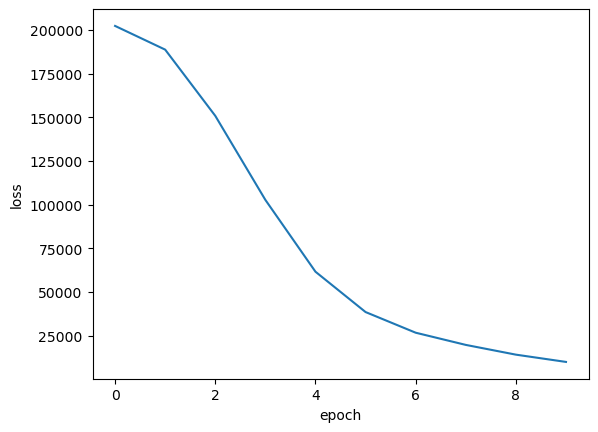

In [90]:
rnn_lstm = Sequential()
rnn_lstm.add(tf.keras.Input(shape = (WINDOW_SIZE,1)))
rnn_lstm.add(tkl.LSTM(units=32, input_shape=(WINDOW_SIZE,1)))
rnn_lstm.add(tkl.Dropout(0.2))
rnn_lstm.add(tkl.Dense(10, activation="relu"))
rnn_lstm.add(tkl.Dense(1))
rnn_lstm.summary()

rnn_lstm.compile(optimizer="adam", loss="mean_squared_error")
history = rnn_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=0)

plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [93]:
pred_train.shape

(8090,)

In [94]:
train_results = pd.DataFrame({"Predictions": pred_train, "Actuals": y_train})
train_results

,Predictions,Actuals
0,114.551628,62.10
1,122.335838,65.50
2,123.813591,63.90
3,122.769463,84.40
4,138.887253,120.10
...,...,...
8085,601.607239,1135.50
8086,601.606934,1140.00
8087,601.607056,1169.50
8088,601.607605,1163.25


253/253 [==============================] - 1s 2ms/step


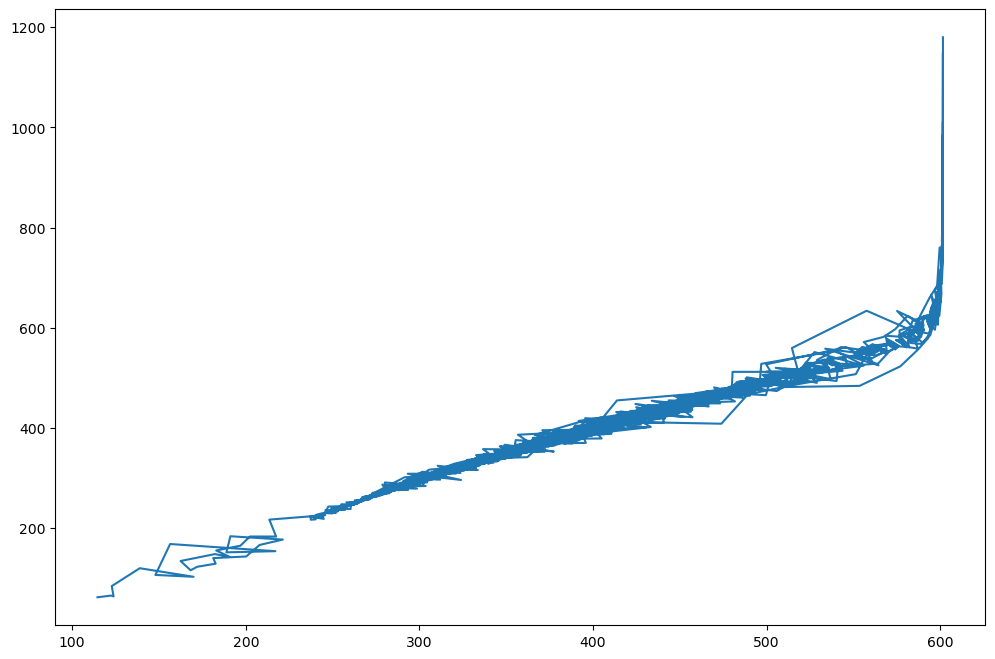

In [92]:
pred_train = rnn_lstm.predict(X_train).flatten()
plt.figure(figsize=(12,8))
plt.plot(pred_train, y_train)
plt.show()

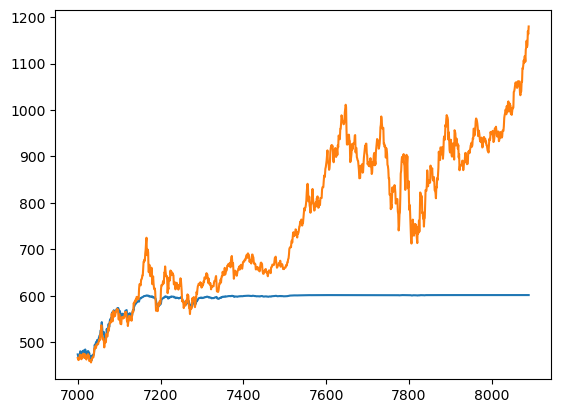

In [103]:
plt.plot(train_results["Predictions"][7000:])
plt.plot(train_results["Actuals"][7000:])

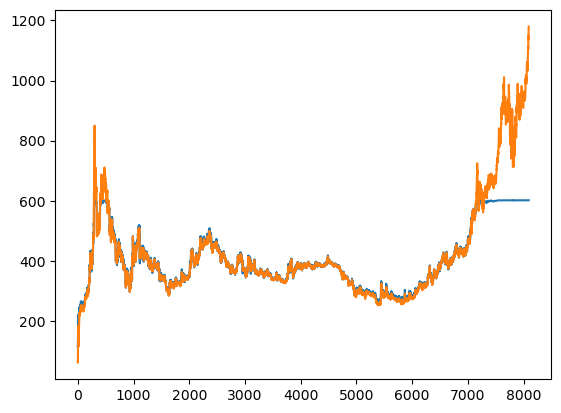

In [104]:
plt.plot(train_results["Predictions"])
plt.plot(train_results["Actuals"])

In [1]:
# after 7000 model couldn't extrapolate, couldn't predict the values above this range before and
# panicked when that peak happened

In [105]:
pred_val = rnn_lstm.predict(X_test).flatten()
val_results = pd.DataFrame({"Predictions": pred_val, "Actuals": y_test})

84/84 [==============================] - 0s 2ms/step


In [106]:
val_results

,Predictions,Actuals
0,601.607727,1182.75
1,601.607727,1166.50
2,601.607483,1175.75
3,601.607666,1192.50
4,601.607849,1212.50
...,...,...
2682,601.216614,1672.50
2683,601.199951,1655.70
2684,601.219055,1653.75
2685,601.231934,1570.70


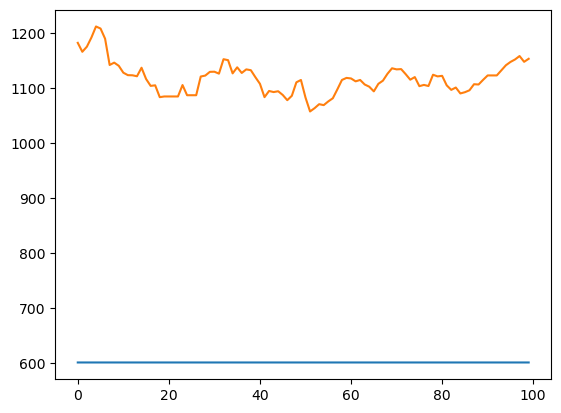

In [108]:
plt.plot(val_results["Predictions"][:100])
plt.plot(val_results["Actuals"][:100])
plt.show()

In [ ]:
#yeah it does very poorly...

In [95]:
rmse = np.sqrt(mean_squared_error(pred_train, y_train))

In [96]:
rmse

82.79301461485292

21/21 [==============================] - 0s 7ms/step


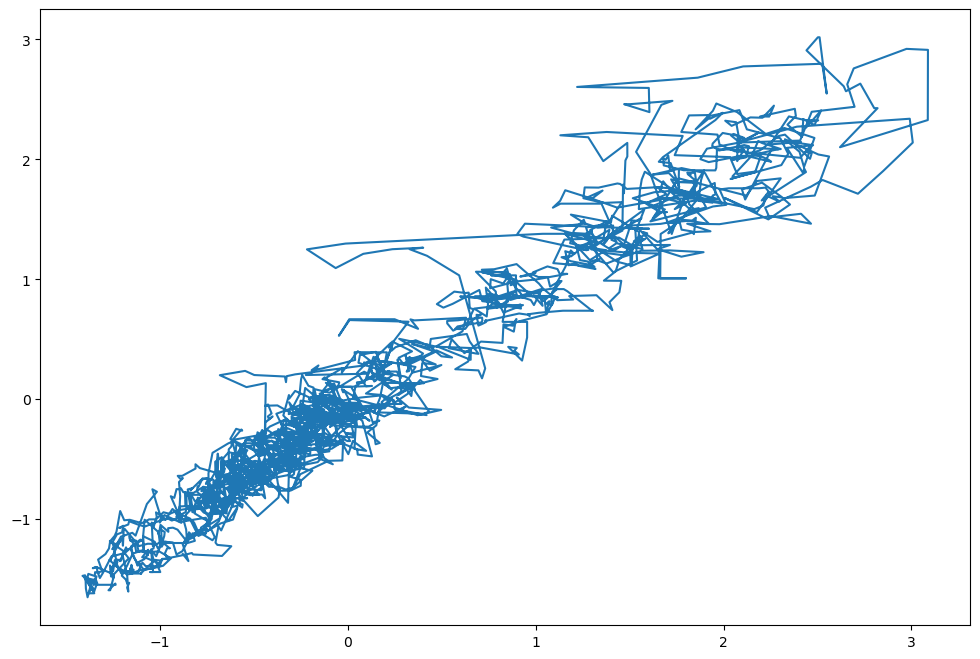

In [38]:
pred = rnn_lstm.predict(dataset_test)
plt.figure(figsize=(12,8))
plt.plot(pred, X_test[:2678])
plt.show()

In [ ]:
# also try model.predict().flatten()
#and try without scaling
#

# Holy!! STATE OF ART this is:)

64/64 [==============================] - 0s 6ms/step


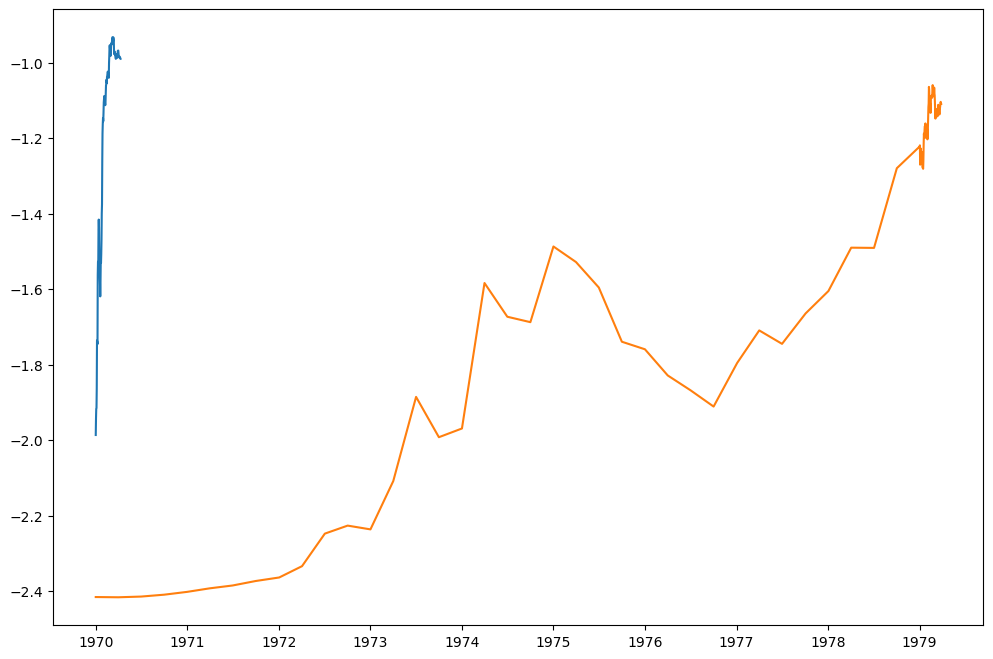

In [52]:
#Let's plot it again
pred = rnn_lstm.predict(dataset)
plt.figure(figsize=(12,8))
plt.plot(pred[:100])
plt.plot(X_train[:100])
plt.show()

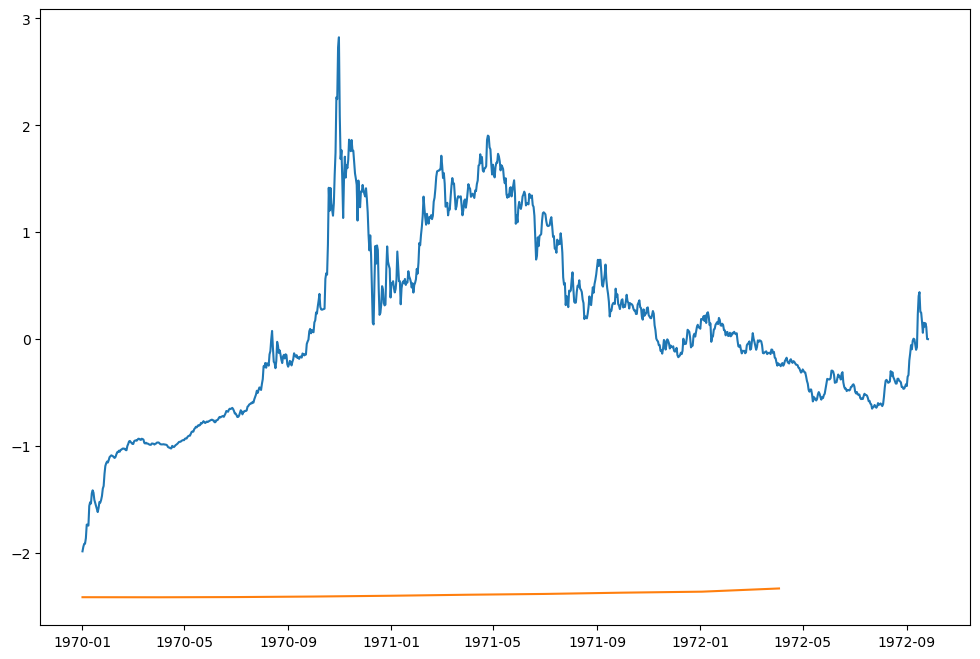

In [55]:
plt.figure(figsize=(12,8))
plt.plot(pred[:1000])
plt.plot(X_train[:10])
plt.show()

In [ ]:
#these crazy plots happened because we couldn't prepare the data properly earlier
#(with the built-in preprocessing >> timeseriesdatasetfromarray) 

In [ ]:
# interpolated version
# decomposing
# maybe use FFT or STL
# google seq2seq >>> encoder-decoder approach
# change the dataset.. maybe use periodic data since gold's too ambitious
# maybe lstm isn't the best way to go with this task

https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network